<a href="https://colab.research.google.com/github/VidushiBhatia/U-Net-Implementation/blob/main/U_Net_for_Image_Segmentation_From_Scratch_Using_TensorFlow_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a name='1'></a>
# 1 - Packages

In [1]:
# for data load
import os

# for reading and processing images
import imageio
from PIL import Image

# for visualizations
import matplotlib.pyplot as plt

import numpy as np # for using np arrays
import cv2

# for bulding and running deep learning model
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

2022-05-12 11:17:54.302114: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


<a name='2'></a>
# 2 - Helper Functions for Data Processing

<a name='2.1'></a>
## 2.1 - Load Data
* the masked images are stored as png, unmasked (original) as jpg
* the names of these 2 are same so for getting the right sample we can just sort the 2 lists

In [2]:
def LoadData (path1, path2):
    """
    Looks for relevant filenames in the shared path
    Returns 2 lists for original and masked files respectively
    
    """
    # Read the images folder like a list
    image_dataset = os.listdir(path1)
    mask_dataset = os.listdir(path2)

    # Make a list for images and masks filenames
    orig_img = []
    mask_img = []
    #for file in image_dataset:
    #    orig_img.append(file)
    for file in mask_dataset:
        ######Pets
#         mask_img.append(file)
#         name = file.replace('.png','.jpg')
#         orig_img.append(name)
        
        ######PAM
        mask_img.append(file)
        name = file.replace('_mask','')
        orig_img.append(name)
    
    # Sort the lists to get both of them in same order (the dataset has exactly the same name for images and corresponding masks)
    orig_img.sort()
    mask_img.sort()
    
    return orig_img, mask_img

<a name='2.2'></a>
## 2.2 - Pre-Process Data

In [3]:
def PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2):
    """
    Processes the images and mask present in the shared list and path
    Returns a NumPy dataset with images as 3-D arrays of desired size
    Please note the masks in this dataset have only one channel
    """
    # Pull the relevant dimensions for image and mask
    m = len(img)                     # number of images
    i_h,i_w,i_c = target_shape_img   # pull height, width, and channels of image
    m_h,m_w,m_c = target_shape_mask  # pull height, width, and channels of mask
    
    # Define X and Y as number of images along with shape of one image
    #X = np.zeros((m,i_h,i_w,i_c), dtype=np.float32)
    
    X = np.zeros((m,i_h,i_w,i_c), dtype=np.dtype('float64'))
    y = np.zeros((m,m_h,m_w,m_c), dtype=np.int32)
    
    # Resize images and masks
    for file in img:
        # convert image into an array of desired shape (3 channels)
        index = img.index(file)
        path = os.path.join(path1, file)
        #single_img = Image.open(path).convert('RGB')
        #single_img = imageio.imread(path)
        single_img = cv2.imread(path)
#         print(path)
#         print("Single image type 1: ", type(single_img))
#         print("Single image shape 1: ", single_img.shape)
        #single_img = single_img.resize((i_h,i_w))
        single_img = cv2.resize(single_img, (i_h, i_w))
#         print("Single image data 2: ", single_img[1][1])
#         print("Single image shape 2: ", single_img.shape)
#         print("Single image type 2: ", type(single_img))
#         print("channels: ", i_c)
        #print("Single image pixel 2: ", single_img.getpixel((1,1)))
        single_img = np.reshape(single_img,(i_h,i_w,i_c))
#         print("Single Image content: ", single_img[1][1])
#         print("Single image type 3: ", type(single_img))
        single_img = single_img/256.
#         print("Single image type 4: ", type(single_img))
        X[index] = single_img
        
        # convert mask into an array of desired shape (1 channel)
        single_mask_ind = mask[index]
        path = os.path.join(path2, single_mask_ind)
        single_mask = Image.open(path).convert("L")
        single_mask = single_mask.resize((m_h, m_w))
        single_mask = np.reshape(single_mask,(m_h,m_w,m_c))
        single_mask = single_mask.astype('float32')
        #single_mask[single_mask >= 200] = 255.0  
        #single_mask[single_mask < 200] = 0
        #single_mask[single_mask == 1] = 255.0
        #1 lila
        #2 türkis
        #3 gelb
        
        #single_mask[single_mask == 1] = 1
        #single_mask[single_mask == 3] = 1
        #single_mask[single_mask == 2] = 0
        
        single_mask[single_mask >= 200] = 255.0  
        single_mask[single_mask < 200] = 0
        single_mask[single_mask == 255.0] = 1.0
        #single_mask = single_mask/256
        #single_mask = single_mask - 1 # to ensure classes #s start from 0
        y[index] = single_mask
    return X, y

<a name='3'></a>
#3 - Constructing the U-Net Architecture


<a name='3.1'></a>
## 3.1 - U-Net Encoder Block

In [4]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning. 
    Dropout can be added for regularization to prevent overfitting. 
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow 
    # Proper initialization prevents from the problem of exploding and vanishing gradients 
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size) 
    conv = Conv2D(n_filters, 
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters, 
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
    
    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions      
    skip_connection = conv
    
    return next_layer, skip_connection

<a name='3.2'></a>
## 3.2 - U-Net Decoder Block

In [5]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input], axis=3)
    
    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters, 
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

<a name='3.3'></a>
## 3.3 - Compile U-Net Blocks

In [6]:
def UNetCompiled(input_size=(128, 128, 3), n_filters=32, n_classes=3):
   """
   Combine both encoder and decoder blocks according to the U-Net research paper
   Return the model as output 
   """
    # Input size represent the size of 1 image (the size used for pre-processing) 
   inputs = Input(input_size)
    
    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image 
   cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
   cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
   cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
   cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
   cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 
    
    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
   ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
   ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
   ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
   ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

    # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size. 
    # Observe the number of channels will be equal to number of output classes
   conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

   conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    # Define the model
   model = tf.keras.Model(inputs=inputs, outputs=conv10)

   return model

<a name='4'></a>
# 4 - Executing above Functions to Train the Model

<a name='4.1'></a>
## 4.1 - Load and View Data

212
212
<class 'imageio.core.util.Array'>
(1080, 1920)
(1080, 1920)
4608
[ 30. 215.]
<class 'imageio.core.util.Array'>
(1080, 1920)
(1080, 1920)
4608
[ 30. 215.]


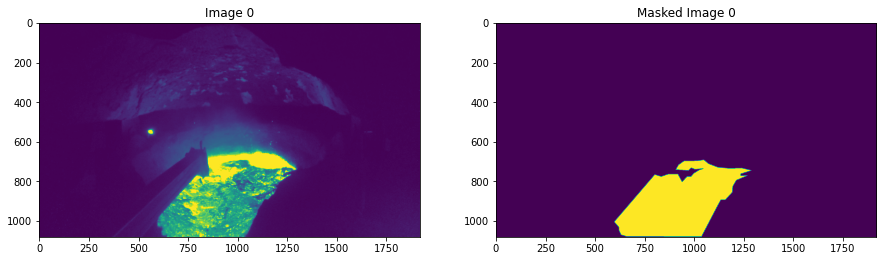

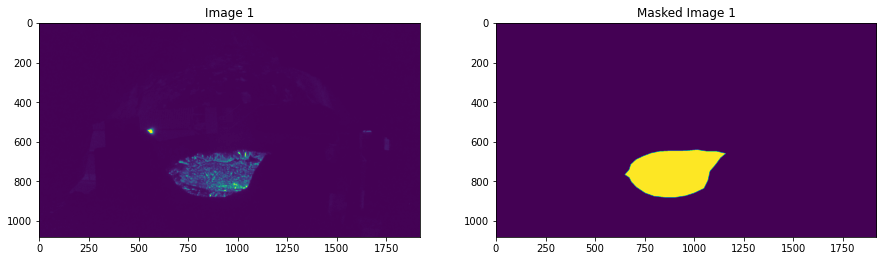

In [7]:
""" Load Train Set and view some examples """
# Call the apt function
path1 = 'path_to_images'
path2 = 'path_to_masks'

img, mask = LoadData (path1, path2)
print(len(img))
print(len(mask))

# View an example of image and corresponding mask 
show_images = 2
for i in range(show_images):
    img_view  = imageio.imread(path1 + img[i])
    print(type(img_view))
    mask_view = np.array(Image.open(path2 + mask[i]).convert("L"), dtype=np.float32)
    print(img_view.shape)
    print(mask_view.shape)
    print(img_view[0][0])
    print(np.unique(mask_view))
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(img_view)
    arr[0].set_title('Image '+ str(i))
    arr[1].imshow(mask_view)
    arr[1].set_title('Masked Image '+ str(i))

<a name='4.2'></a>
## 4.2 - Process Data

X Shape: (212, 960, 960, 3)
X 0 Shape: (960, 960, 3)
X 0 Type: <class 'numpy.ndarray'>
[0.23046875 0.23046875 0.23046875]
Y shape: (212, 960, 960, 1)
Y 0 Shape: (960, 960, 1)
Y 0 Type: <class 'numpy.ndarray'>
[0]


Text(0.5, 1.0, 'Processed Masked Image ')

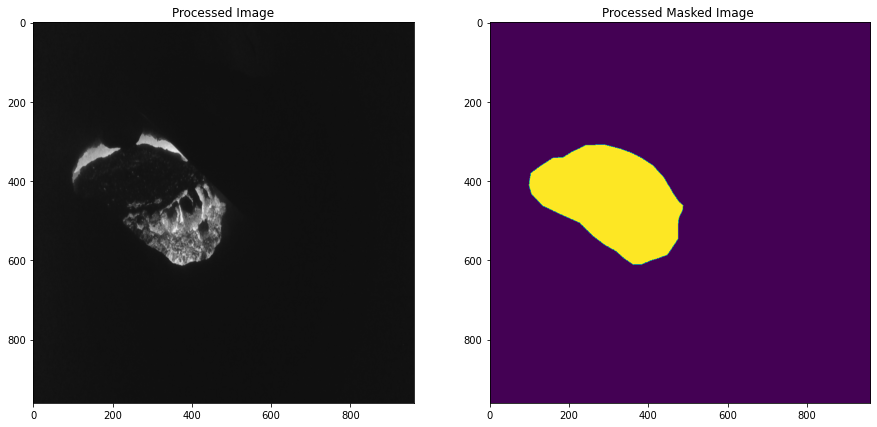

In [8]:
# Define the desired shape
target_shape_img = [960, 960, 3]
target_shape_mask = [960, 960, 1]

# Process data using apt helper function

X, y = PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2)

# QC the shape of output and classes in output dataset 
print("X Shape:", X.shape)
print("X 0 Shape:", X[0].shape)
print("X 0 Type:", type(X[0]))
#print("X 0 unique vals: ", np.unique(X[12]))
print(X[12][250][250])

print(20*'=')
print("Y shape:", y.shape)
print("Y 0 Shape:", y[0].shape)
print("Y 0 Type:", type(y[0]))
#print("Y 0 unique vals: ", np.unique(y[12]))
print(y[12][250][250])
# There are 3 classes : background, pet, outline

# Visualize the output
image_index = 2
fig, arr = plt.subplots(1, 2, figsize=(15, 15))

arr[0].imshow(X[image_index])
arr[0].set_title('Processed Image')

arr[1].imshow(y[image_index])
arr[1].set_title('Processed Masked Image ')

## 4.3 - Split Train and Test Set

In [9]:
# Use scikit-learn's function to split the dataset
# Here, I have used 20% data as test/valid set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=77)
print(len(X_train))

169


<a name='4.4'></a>
## 4.4 - Build U-Net Architecture

In [ ]:
# Call the helper function for defining the layers for the model, given the input image size
unet = UNetCompiled(input_size=(960,960,3), n_filters=32, n_classes=1)
#unet = tf.keras.models.load_model('models/')


In [11]:
# Check the summary to better interpret how the output dimensions change in each layer
unet.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 960, 960, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 960, 960, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 960, 960, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 960, 960, 32) 128         conv2d_1[0][0]                   
______________________________________________________________________________________________

<a name='4.5'></a>
## 4.5 - Compile and Run Model

In [12]:
# There are multiple optimizers, loss functions and metrics that can be used to compile multi-class segmentation models
# Ideally, try different options to get the best accuracy

unet.compile(optimizer=tf.keras.optimizers.Adam(), 
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# unet.compile(optimizer=tf.keras.optimizers.SGD(lr=3e-5), 
#              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               metrics=['accuracy'])



<a name='3'></a>
In this case the accuracy is stagnant at ~80%. Possible reasons/approaches:
- Pick different Optimizer
-- Tweak Learning rate for non-adaptive optimizer
- use more images
- Optimizer has found a local minimum, which is to always predict the most common class.

In [15]:
# Run the model in a mini-batch fashion and compute the progress for each epoch
results = unet.fit(X_train, y_train, batch_size=2, epochs=200, validation_data=(X_valid, y_valid))

2022-05-12 11:24:10.935937: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1869004800 exceeds 10% of free system memory.


Epoch 1/200
85/85 [==============================] - 67s 733ms/step - loss: 0.1935 - accuracy: 0.9684 - val_loss: 0.0983 - val_accuracy: 0.9709
Epoch 2/200
85/85 [==============================] - 53s 619ms/step - loss: 0.1067 - accuracy: 0.9693 - val_loss: 0.1011 - val_accuracy: 0.9709
Epoch 3/200
85/85 [==============================] - 53s 622ms/step - loss: 0.0995 - accuracy: 0.9692 - val_loss: 0.0935 - val_accuracy: 0.9709
Epoch 4/200
85/85 [==============================] - 53s 620ms/step - loss: 0.1103 - accuracy: 0.9693 - val_loss: 0.2990 - val_accuracy: 0.9709
Epoch 5/200
85/85 [==============================] - 53s 622ms/step - loss: 0.1112 - accuracy: 0.9693 - val_loss: 0.0737 - val_accuracy: 0.9709
Epoch 6/200
85/85 [==============================] - 53s 621ms/step - loss: 0.1015 - accuracy: 0.9693 - val_loss: 0.1286 - val_accuracy: 0.9709
Epoch 7/200
85/85 [==============================] - 52s 612ms/step - loss: 0.0883 - accuracy: 0.9693 - val_loss: 0.0925 - val_accuracy:

85/85 [==============================] - 52s 612ms/step - loss: 0.0604 - accuracy: 0.9765 - val_loss: 0.0577 - val_accuracy: 0.9739
Epoch 58/200
85/85 [==============================] - 52s 613ms/step - loss: 0.0602 - accuracy: 0.9765 - val_loss: 0.0526 - val_accuracy: 0.9787
Epoch 59/200
85/85 [==============================] - 52s 612ms/step - loss: 0.0589 - accuracy: 0.9761 - val_loss: 0.0537 - val_accuracy: 0.9775
Epoch 60/200
85/85 [==============================] - 52s 612ms/step - loss: 0.0585 - accuracy: 0.9773 - val_loss: 0.0514 - val_accuracy: 0.9783
Epoch 61/200
85/85 [==============================] - 52s 612ms/step - loss: 0.0569 - accuracy: 0.9784 - val_loss: 0.0599 - val_accuracy: 0.9757
Epoch 62/200
85/85 [==============================] - 52s 613ms/step - loss: 0.0577 - accuracy: 0.9779 - val_loss: 0.0517 - val_accuracy: 0.9791
Epoch 63/200
85/85 [==============================] - 52s 612ms/step - loss: 0.0580 - accuracy: 0.9787 - val_loss: 0.0535 - val_accuracy: 0.979

85/85 [==============================] - 52s 612ms/step - loss: 0.0490 - accuracy: 0.9821 - val_loss: 0.0485 - val_accuracy: 0.9788
Epoch 114/200
85/85 [==============================] - 52s 612ms/step - loss: 0.0487 - accuracy: 0.9821 - val_loss: 0.0478 - val_accuracy: 0.9831
Epoch 115/200
85/85 [==============================] - 52s 612ms/step - loss: 0.0619 - accuracy: 0.9804 - val_loss: 0.0485 - val_accuracy: 0.9810
Epoch 116/200
85/85 [==============================] - 52s 611ms/step - loss: 0.0490 - accuracy: 0.9828 - val_loss: 0.0442 - val_accuracy: 0.9834
Epoch 117/200
85/85 [==============================] - 52s 611ms/step - loss: 0.0470 - accuracy: 0.9835 - val_loss: 0.0490 - val_accuracy: 0.9827
Epoch 118/200
85/85 [==============================] - 52s 611ms/step - loss: 0.0489 - accuracy: 0.9826 - val_loss: 0.0449 - val_accuracy: 0.9815
Epoch 119/200
85/85 [==============================] - 52s 611ms/step - loss: 0.0480 - accuracy: 0.9831 - val_loss: 0.0446 - val_accuracy:

85/85 [==============================] - 54s 630ms/step - loss: 0.0406 - accuracy: 0.9863 - val_loss: 0.0388 - val_accuracy: 0.9848
Epoch 170/200
85/85 [==============================] - 53s 622ms/step - loss: 0.0402 - accuracy: 0.9863 - val_loss: 0.0413 - val_accuracy: 0.9850
Epoch 171/200
85/85 [==============================] - 52s 617ms/step - loss: 0.0381 - accuracy: 0.9874 - val_loss: 0.0392 - val_accuracy: 0.9853
Epoch 172/200
85/85 [==============================] - 52s 617ms/step - loss: 0.0365 - accuracy: 0.9882 - val_loss: 0.0373 - val_accuracy: 0.9862
Epoch 173/200
85/85 [==============================] - 52s 617ms/step - loss: 0.0371 - accuracy: 0.9877 - val_loss: 0.0395 - val_accuracy: 0.9857
Epoch 174/200
85/85 [==============================] - 53s 618ms/step - loss: 0.0381 - accuracy: 0.9874 - val_loss: 0.0397 - val_accuracy: 0.9857
Epoch 175/200
85/85 [==============================] - 53s 619ms/step - loss: 0.0369 - accuracy: 0.9880 - val_loss: 0.0389 - val_accuracy:

<a name='5'></a>
# 5 - Evaluate Model Results

<a name='5.1'></a>
## 5.1 - Bias Variance Check

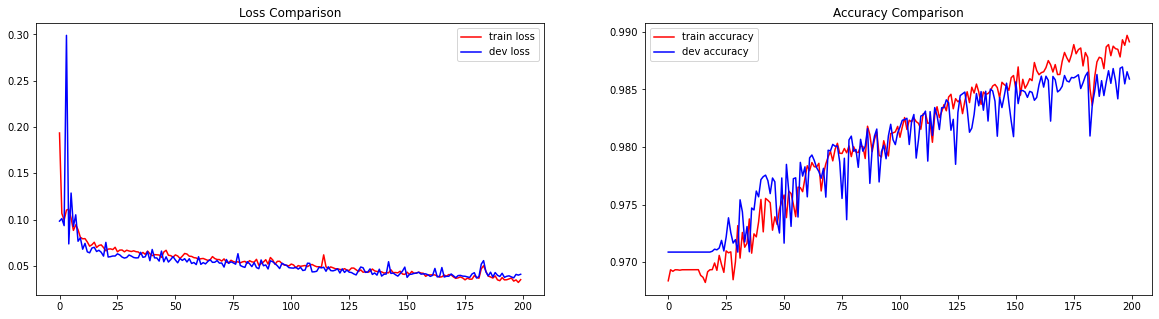

In [16]:
# High Bias is a characteristic of an underfitted model and we would observe low accuracies for both train and validation set
# High Variance is a characterisitic of an overfitted model and we would observe high accuracy for train set and low for validation set
# To check for bias and variance plit the graphs for accuracy 
# I have plotted for loss too, this helps in confirming if the loss is decreasing with each iteration - hence, the model is optimizing fine
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(results.history["loss"], color='r', label = 'train loss')
axis[0].plot(results.history["val_loss"], color='b', label = 'dev loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(results.history["val_accuracy"], color='b', label = 'dev accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()

# RESULTS
# The train loss is consistently decreasing showing that Adam is able to optimize the model and find the minima
# The accuracy of train and validation is ~90% which is high enough, so low bias
# and the %s aren't that far apart, hence low variance

<a name='5.2'></a>
## 5.2 - View Predicted Segmentations

In [17]:
unet.evaluate(X_valid, y_valid)

2022-05-12 14:26:23.509598: W tensorflow/core/common_runtime/bfc_allocator.cc:433] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.52GiB (rounded to 3774873600)requested by op model/conv2d_1/Relu
Current allocation summary follows.
2022-05-12 14:26:23.509625: I tensorflow/core/common_runtime/bfc_allocator.cc:972] BFCAllocator dump for GPU_0_bfc
2022-05-12 14:26:23.509635: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (256): 	Total Chunks: 100, Chunks in use: 99. 25.0KiB allocated for chunks. 24.8KiB in use in bin. 9.6KiB client-requested in use in bin.
2022-05-12 14:26:23.509641: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (512): 	Total Chunks: 23, Chunks in use: 23. 11.8KiB allocated for chunks. 11.8KiB in use in bin. 11.5KiB client-requested in use in bin.
2022-05-12 14:26:23.509647: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (1024): 	Total Chunks: 24, Chunks in use: 24. 24.2KiB allocated for chunks. 24.2KiB in use in bin. 24.0

ResourceExhaustedError:  OOM when allocating tensor with shape[32,32,960,960] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/conv2d_1/Relu (defined at tmp/ipykernel_130485/3635428684.py:2) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_test_function_4073]

Function call stack:
test_function


In [18]:
# Results of Validation Dataset
def VisualizeResults(index):
    img = X_valid[index]
    img = img[np.newaxis, ...]
    pred_y = unet.predict(img)
    pred_y[pred_y > 0.0] = 1.0
    pred_y[pred_y < 0.0] = 0.0
    pred_y = pred_y.squeeze()
    #print("Prediction Mask Max Val: ", np.amax(pred_y))
    #print("Prediction Mask Min Val: ", np.amin(pred_y))
    #print("Prediction Mask Shape: ", pred_y.shape)
    #print("Actual Image Max Val: ", np.amax(X_valid[index]))
    #print("Actual Image Min Val: ", np.amin(X_valid[index]))
    #print("Actual Image Shape: ", X_valid[index].shape)
    
    #simple numpy addition
    result_true = X_valid[index].copy()
    result_true[y_valid[index,:,:,0]!=0] += (0.6,0.6,0)
    
    #simple numpy addition
    result_pred = X_valid[index].copy()
    result_pred[pred_y!=0] += (0.6,0.6,0)
    
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(result_true)
    arr[0].set_title('Actual Mask')
    arr[1].imshow(result_pred)
    arr[1].set_title('Predicted Mask ')
    
    imageio.imwrite('images/mask_{}_labeled.png'.format(index), result_true)
    imageio.imwrite('images/mask_{}_predicted.png'.format(index), result_pred)
   
    

In [ ]:
# Add any index to contrast the predicted mask with actual mask
#index = 15
for index in range(len(X_valid)):
    VisualizeResults(index)

In [20]:
# Save the model

unet.save('/home/messnix/pam_ws/src/amt-pam-semantic-segmentation/models/')

2022-05-12 14:30:31.598268: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/messnix/pam_ws/src/amt-pam-semantic-segmentation/models/assets
